<a href="https://colab.research.google.com/github/mollah2022/Neural-Network/blob/main/new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# -------------------------------
# 1. Libraries
# -------------------------------
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import community as community_louvain  # pip install python-louvain


In [ ]:
# -------------------------------
# 2. Load dataset
# -------------------------------
file_path = "/content/drive/MyDrive/CSE - 314/dhaka_dengue_weather_2021_2024.csv"
df = pd.read_csv(file_path)
df['date'] = pd.to_datetime(df.get('date', pd.date_range(start='2021-01-01', periods=len(df))), errors='coerce')
df = df.sort_values('date')


In [ ]:
# -------------------------------
# 3. Feature Engineering
# -------------------------------
df['lag1'] = df['Previous_Day_Dengue_Cases']
df['lag2'] = df['Previous_Day_Dengue_Cases'].shift(1).fillna(df['Previous_Day_Dengue_Cases'])
df['lag3'] = df['Previous_Day_Dengue_Cases'].shift(2).fillna(df['Previous_Day_Dengue_Cases'])
df['lag3_mean'] = df[['lag1','lag2','lag3']].mean(axis=1)
df['lag7'] = df['Previous_Day_Dengue_Cases'].rolling(7).mean().fillna(0)
df['lag14'] = df['Previous_Day_Dengue_Cases'].rolling(14).mean().fillna(0)
df['lag28'] = df['Previous_Day_Dengue_Cases'].rolling(28).mean().fillna(0)
df['diff7'] = df['lag7'] - df['lag14']  # trend
df['Temp_roll7'] = df['Temperature'].rolling(7).mean().fillna(df['Temperature'])
df['Hum_roll7'] = df['Humidity'].rolling(7).mean().fillna(df['Humidity'])
df['Rain_roll7'] = df['Rainfall_mm'].rolling(7).mean().fillna(df['Rainfall_mm'])
df['Temp_Hum'] = df['Temperature'] * df['Humidity']
df['Rain_Hum'] = df['Rainfall_mm'] * df['Humidity']
df['Temp_Rain'] = df['Temperature'] * df['Rainfall_mm']
df['Temp_Rain_Hum'] = df['Temperature']*df['Rainfall_mm']*df['Humidity']
df['Hum_std7'] = df['Humidity'].rolling(7).std().fillna(df['Humidity'])
df['Rain_std7'] = df['Rainfall_mm'].rolling(7).std().fillna(df['Rainfall_mm'])
df['weekday'] = df['date'].dt.weekday
df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x>=5 else 0)
df['day_of_year'] = df['date'].dt.dayofyear / 365.0


In [ ]:
# -------------------------------
# 4. Non-Graph-Based Clustering
# -------------------------------
features_clust = df[['Temperature','Humidity','Rainfall_mm','lag1','lag2','lag3','lag7']].values

# KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
df['kmeans_cluster'] = kmeans.fit_predict(features_clust)

# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
df['dbscan_cluster'] = dbscan.fit_predict(features_clust)

# Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=3)
df['agglo_cluster'] = agglo.fit_predict(features_clust)


In [ ]:
# -------------------------------
# 5. Graph-Based Clustering (Corrected)
# -------------------------------
import networkx as nx
import community.community_louvain as community_louvain  # Correct import for Louvain

# Build adjacency matrix (temporal + cluster)
num_nodes = len(df)
adj = np.zeros((num_nodes, num_nodes))

# Temporal edges: last 3 days = 3.0, others = 2.0
for i in range(num_nodes-1):
    w = 3.0 if i >= num_nodes-3 else 2.0
    adj[i,i+1] = w
    adj[i+1,i] = w

# Cluster edges using KMeans
for cluster_id in np.unique(df['kmeans_cluster']):
    nodes = np.where(df['kmeans_cluster']==cluster_id)[0]
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            adj[nodes[i],nodes[j]] = 1.0
            adj[nodes[j],nodes[i]] = 1.0

# ----- Spectral Clustering -----
spectral = SpectralClustering(n_clusters=3, affinity='precomputed', random_state=42)
df['spectral_cluster'] = spectral.fit_predict(adj)

# ----- Louvain / Community Detection -----
G = nx.from_numpy_array(adj)
partition = community_louvain.best_partition(G)  # This works after correct import
df['louvain_cluster'] = df.index.map(partition)

print("Graph-based clustering completed: Spectral & Louvain clusters added to df")


Graph-based clustering completed: Spectral & Louvain clusters added to df


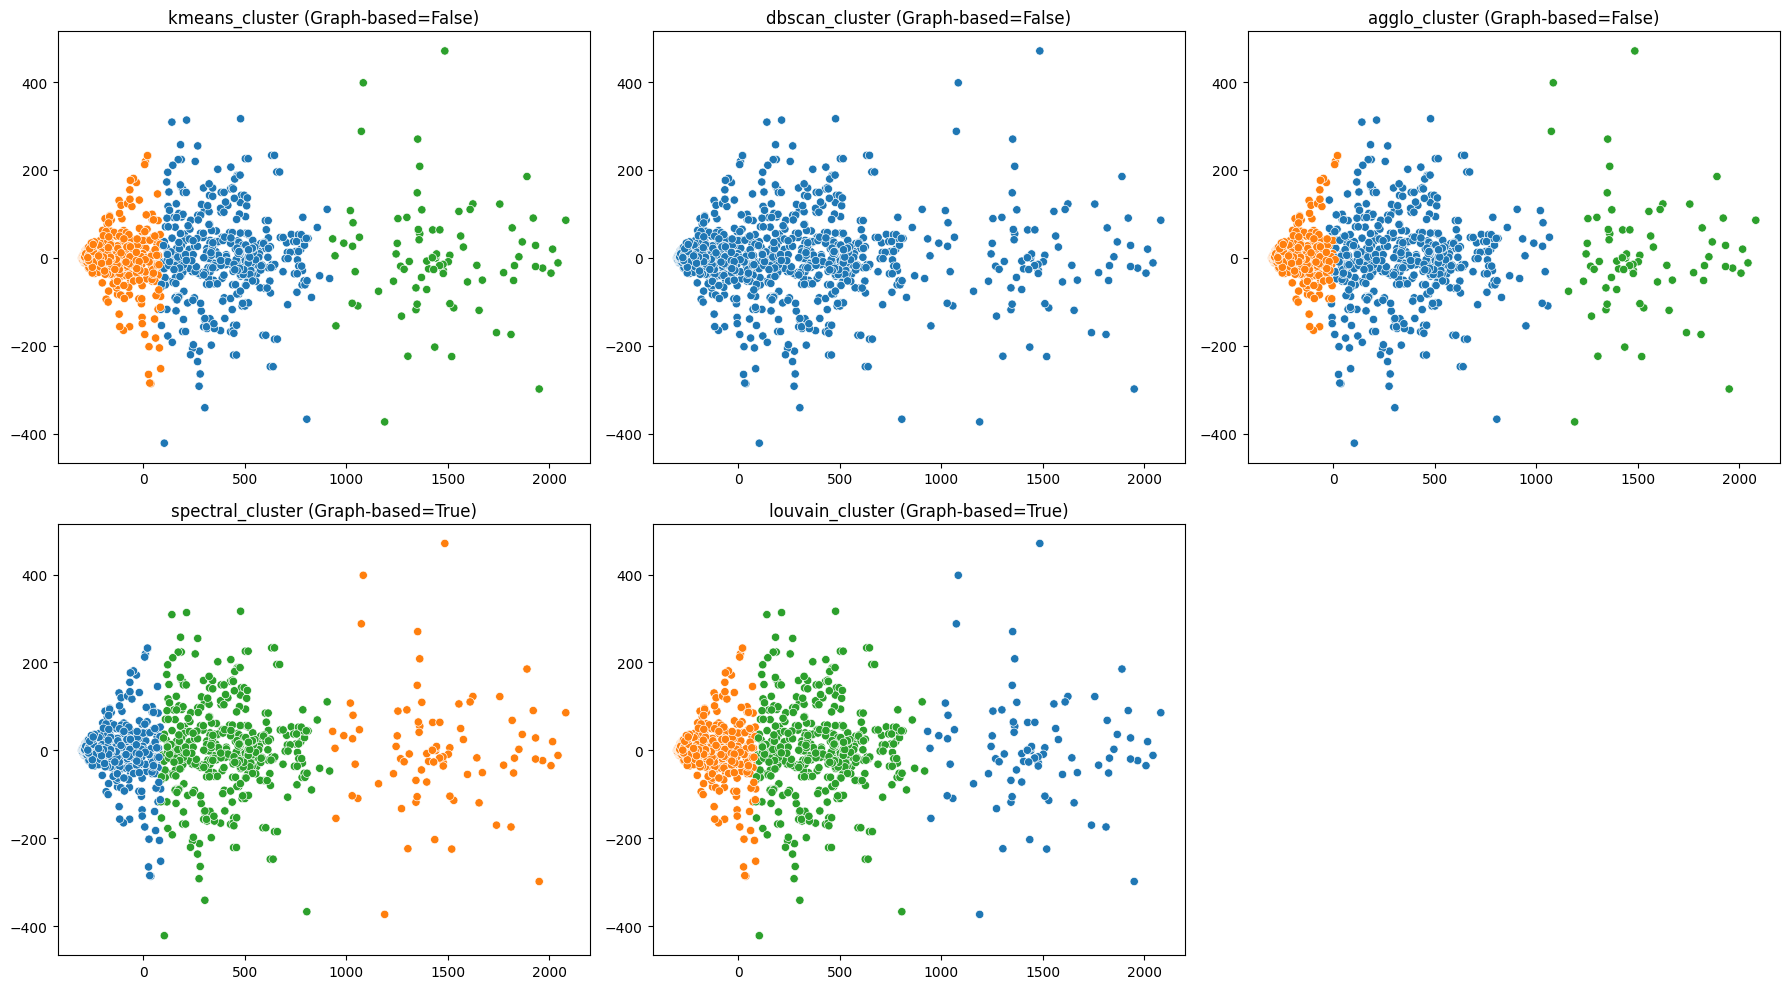

In [ ]:
# -------------------------------
# 6. Cluster Visualization
# -------------------------------
X_vis = features_clust
X_pca = PCA(n_components=2).fit_transform(X_vis)
cluster_cols = ['kmeans_cluster','dbscan_cluster','agglo_cluster','spectral_cluster','louvain_cluster']

plt.figure(figsize=(18,10))
for i, col in enumerate(cluster_cols):
    plt.subplot(2,3,i+1)
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df[col], palette='tab10')
    plt.title(f"{col} (Graph-based={col in ['spectral_cluster','louvain_cluster']})")
    plt.legend([],[], frameon=False)
plt.tight_layout()
plt.show()


In [ ]:
# -------------------------------
# 7. Silhouette Score Comparison
# -------------------------------
for col in cluster_cols:
    labels = df[col]
    if len(set(labels)) > 1:
        score = silhouette_score(features_clust, labels)
        print(f"{col} Silhouette Score: {score:.4f}")


kmeans_cluster Silhouette Score: 0.6994
agglo_cluster Silhouette Score: 0.6838
spectral_cluster Silhouette Score: 0.6994
louvain_cluster Silhouette Score: 0.6994


In [ ]:
# -------------------------------
# 8. Prepare Features & Target
# -------------------------------
def prepare_features(cluster_col):
    cluster_onehot = OneHotEncoder(sparse_output=False).fit_transform(df[[cluster_col]])
    cluster_features = torch.tensor(cluster_onehot, dtype=torch.float)

    feature_cols = ['Temperature','Humidity','Rainfall_mm','lag1','lag2','lag3','lag3_mean','lag7','lag14','lag28','diff7',
                    'Temp_roll7','Hum_roll7','Rain_roll7','Temp_Hum','Rain_Hum','Temp_Rain','Temp_Rain_Hum',
                    'Hum_std7','Rain_std7','is_weekend','day_of_year']
    X_raw = df[feature_cols].values
    scaler_X = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X_raw)
    X = torch.tensor(X_scaled, dtype=torch.float)
    X = torch.cat([X, cluster_features], dim=1)

    y = df['Dengue_Cases'].values.reshape(-1,1)
    scaler_y = MinMaxScaler()
    y_scaled = scaler_y.fit_transform(y)
    y = torch.tensor(y_scaled, dtype=torch.float)

    return X, y, scaler_y


In [ ]:
# -------------------------------
# 9. Attention & GCN+LSTM
# -------------------------------
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim,1)
        self.attention_weights = None

    def forward(self,x):
        weights = torch.softmax(self.attn(x), dim=1)
        self.attention_weights = weights
        context = torch.sum(weights * x, dim=1)
        return context

class GCN_StackedBiLSTM_Attn(nn.Module):
    def __init__(self, in_features, hidden_gcn=128, hidden_lstm=256, seq_len=28, dropout=0.25):
        super().__init__()
        self.fc_gcn = nn.Linear(in_features, hidden_gcn)
        self.dropout_gcn = nn.Dropout(dropout)
        self.lstm = nn.LSTM(hidden_gcn, hidden_lstm, batch_first=True, bidirectional=True,
                            num_layers=2, dropout=dropout)
        self.attn = Attention(hidden_lstm*2)
        self.fc_out = nn.Linear(hidden_lstm*2,1)
        self.seq_len = seq_len

    def forward(self,X,A):
        H = F.relu(torch.matmul(A,self.fc_gcn(X)))
        H = self.dropout_gcn(H)
        sequences = []
        for i in range(len(H)-self.seq_len):
            sequences.append(H[i:i+self.seq_len])
        sequences = torch.stack(sequences)
        lstm_out,_ = self.lstm(sequences)
        context = self.attn(lstm_out)
        out = self.fc_out(context)
        return out


In [ ]:
# -------------------------------
# 10. Train-Test Split & Adjacency
# -------------------------------
seq_len = 28
train_idx, test_idx = train_test_split(np.arange(num_nodes-seq_len), test_size=0.2, shuffle=False)
train_idx = torch.tensor(train_idx)
test_idx = torch.tensor(test_idx)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Normalized adjacency
D = np.diag(adj.sum(axis=1)**-0.5)
adj_norm = D @ adj @ D
A = torch.tensor(adj_norm, dtype=torch.float).to(device)


In [ ]:
# -------------------------------
# 11. Training Function
# -------------------------------
def train_gcn(X, y, scaler_y, epochs=300):
    model = GCN_StackedBiLSTM_Attn(X.shape[1], seq_len=seq_len).to(device)
    X, y = X.to(device), y.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=10)
    criterion = nn.SmoothL1Loss()

    gcn_train_losses = []
    gcn_test_losses = []
    gcn_train_accuracies = []
    gcn_test_accuracies = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(X,A)
        loss_train = criterion(out[train_idx], y[train_idx+seq_len])
        loss_train.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            out_test = model(X,A)
            loss_test = criterion(out_test[test_idx], y[test_idx+seq_len])
            pred_test = scaler_y.inverse_transform(out_test[test_idx].cpu().numpy())
            actual_test = scaler_y.inverse_transform(y[test_idx+seq_len].cpu().numpy())
            acc_test = np.mean(np.abs(pred_test-actual_test)<=100)*100

            pred_train = scaler_y.inverse_transform(out[train_idx].cpu().numpy())
            actual_train = scaler_y.inverse_transform(y[train_idx+seq_len].cpu().numpy())
            acc_train = np.mean(np.abs(pred_train-actual_train)<=100)*100

        scheduler.step(loss_test)
        gcn_train_losses.append(loss_train.item())
        gcn_test_losses.append(loss_test.item())
        gcn_train_accuracies.append(acc_train)
        gcn_test_accuracies.append(acc_test)

        if epoch%20==0 or epoch==epochs-1:
            print(f"Epoch {epoch}: Train Loss={loss_train.item():.5f}, Test Loss={loss_test.item():.5f}, Train Acc±100={acc_train:.2f}%, Test Acc±100={acc_test:.2f}%")

    return model, gcn_train_losses, gcn_test_losses, gcn_train_accuracies, gcn_test_accuracies


In [ ]:
# -------------------------------
# 12. Train & Compare Cluster Types
# -------------------------------
cluster_methods = ['kmeans_cluster','dbscan_cluster','agglo_cluster','spectral_cluster','louvain_cluster']
results = {}

for cluster_col in cluster_methods:
    print(f"\n=== Training with {cluster_col} ===")
    X_feat, y_feat, scaler_y = prepare_features(cluster_col)
    model, train_losses, test_losses, train_acc, test_acc = train_gcn(X_feat, y_feat, scaler_y, epochs=100)
    results[cluster_col] = {
        'model': model,
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_acc': train_acc,
        'test_acc': test_acc
    }



=== Training with kmeans_cluster ===
Epoch 0: Train Loss=0.02729, Test Loss=0.00668, Train Acc±100=58.90%, Test Acc±100=71.94%
Epoch 20: Train Loss=0.00501, Test Loss=0.00563, Train Acc±100=70.45%, Test Acc±100=68.06%
Epoch 40: Train Loss=0.00434, Test Loss=0.00474, Train Acc±100=73.57%, Test Acc±100=70.00%
Epoch 60: Train Loss=0.00389, Test Loss=0.00482, Train Acc±100=73.09%, Test Acc±100=70.83%
Epoch 80: Train Loss=0.00387, Test Loss=0.00485, Train Acc±100=73.78%, Test Acc±100=70.56%
Epoch 99: Train Loss=0.00397, Test Loss=0.00483, Train Acc±100=73.16%, Test Acc±100=70.83%

=== Training with dbscan_cluster ===
Epoch 0: Train Loss=0.02361, Test Loss=0.00592, Train Acc±100=63.56%, Test Acc±100=73.33%
Epoch 20: Train Loss=0.00553, Test Loss=0.00622, Train Acc±100=67.66%, Test Acc±100=66.11%
Epoch 40: Train Loss=0.00419, Test Loss=0.00480, Train Acc±100=73.30%, Test Acc±100=70.00%
Epoch 60: Train Loss=0.00392, Test Loss=0.00483, Train Acc±100=72.81%, Test Acc±100=71.39%
Epoch 80: Train 

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay



===== Evaluation for kmeans_cluster =====
MAE: 80.37, MSE: 14522.45, R²: 0.7197


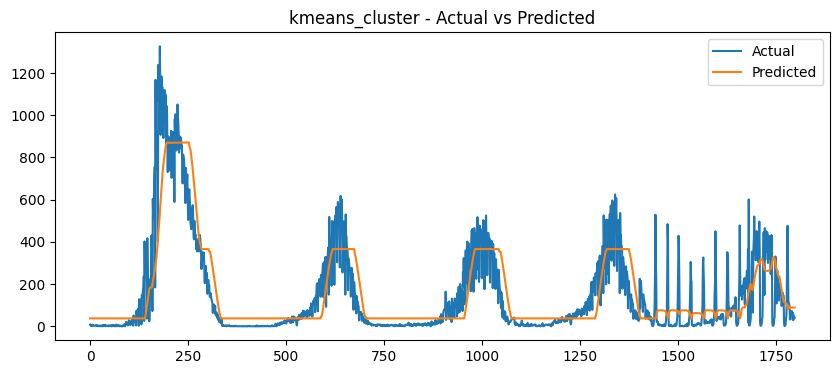


===== Evaluation for dbscan_cluster =====
MAE: 79.54, MSE: 14414.58, R²: 0.7217


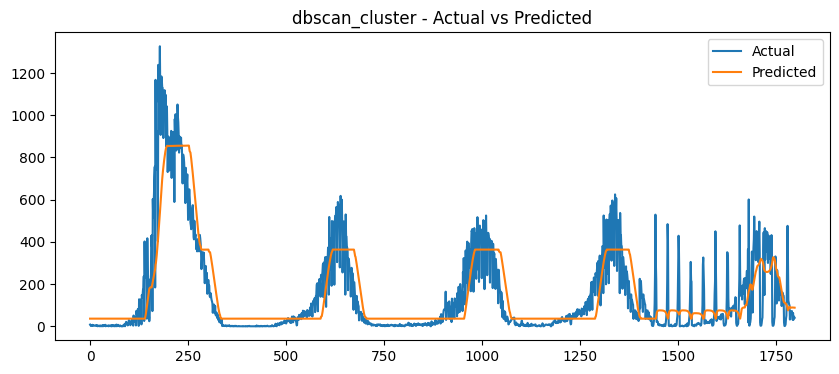


===== Evaluation for agglo_cluster =====
MAE: 79.29, MSE: 14363.62, R²: 0.7227


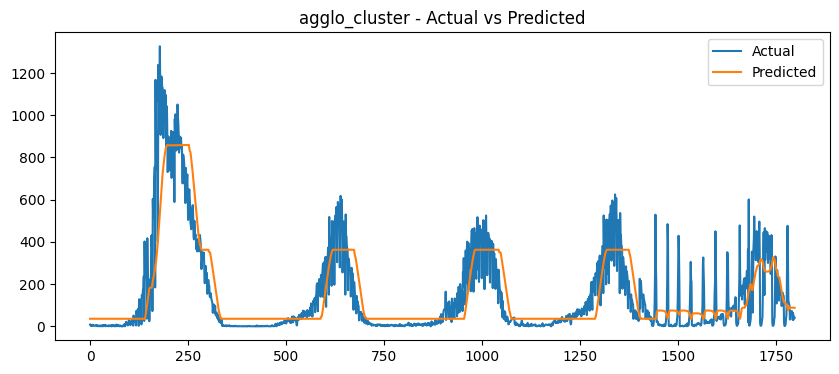


===== Evaluation for spectral_cluster =====
MAE: 79.96, MSE: 14428.62, R²: 0.7215


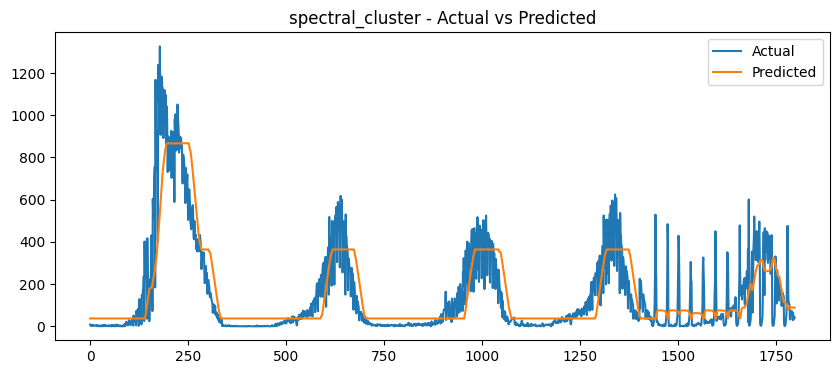


===== Evaluation for louvain_cluster =====
MAE: 79.83, MSE: 14489.67, R²: 0.7203


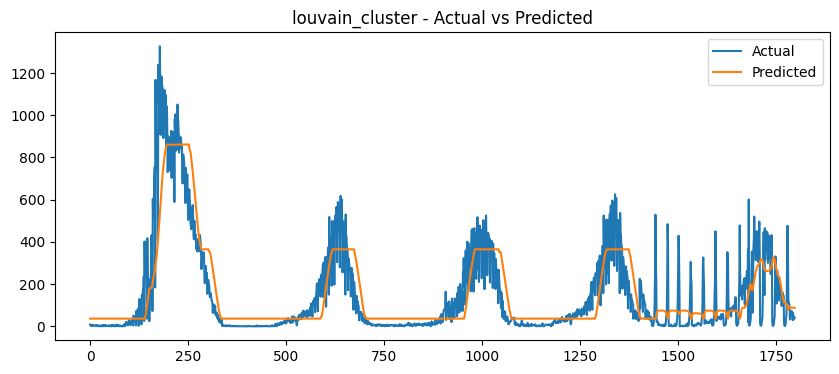

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

for cluster_col in cluster_methods:
    print(f"\n===== Evaluation for {cluster_col} =====")
    res = results[cluster_col]
    model = res['model']

    model.eval()
    with torch.no_grad():
        X_feat, y_feat, scaler_y = prepare_features(cluster_col)
        X_feat, y_feat = X_feat.to(device), y_feat.to(device)
        pred_scaled = model(X_feat,A).cpu().numpy()
        y_true_scaled = y_feat.cpu().numpy()

        # Inverse scale
        pred = scaler_y.inverse_transform(pred_scaled)
        y_true = scaler_y.inverse_transform(y_true_scaled)

        # Align lengths
        min_len = min(len(pred), len(y_true))
        pred = pred[-min_len:]
        y_true = y_true[-min_len:]

        # Regression metrics
        mae = mean_absolute_error(y_true, pred)
        mse = mean_squared_error(y_true, pred)
        r2 = r2_score(y_true, pred)
        print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, R²: {r2:.4f}")

        # Plot actual vs predicted
        plt.figure(figsize=(10,4))
        plt.plot(y_true, label='Actual')
        plt.plot(pred, label='Predicted')
        plt.title(f'{cluster_col} - Actual vs Predicted')
        plt.legend()
        plt.show()



===== Evaluation for kmeans_cluster =====


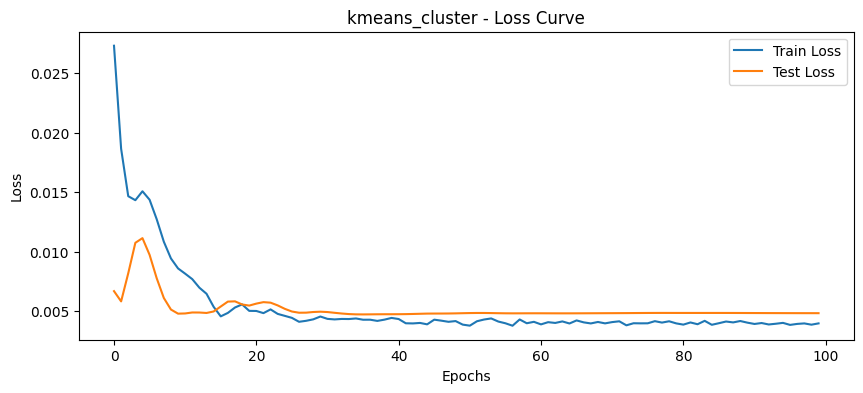

MAE: 80.37, MSE: 14522.45, R²: 0.7197


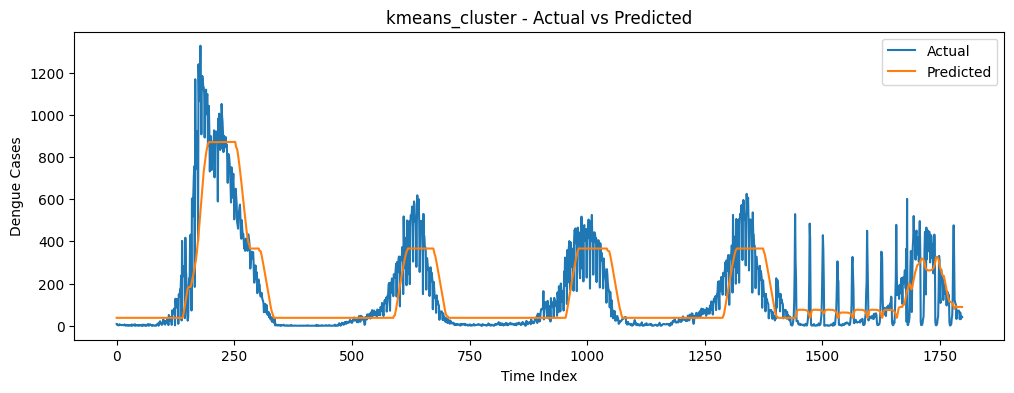


===== Evaluation for dbscan_cluster =====


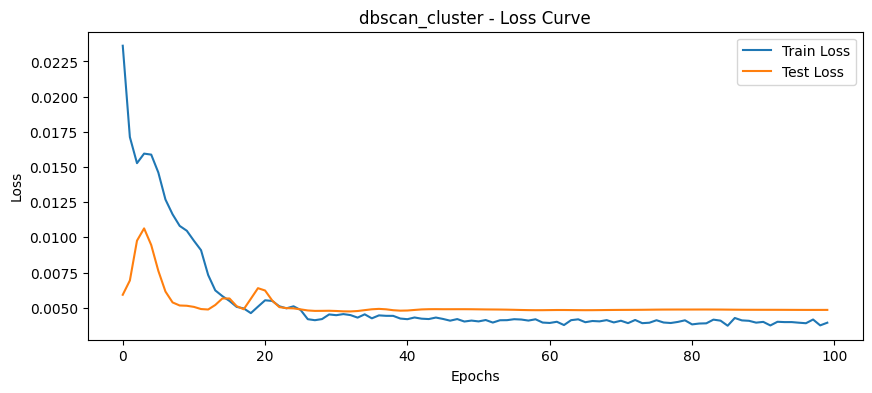

MAE: 79.54, MSE: 14414.58, R²: 0.7217


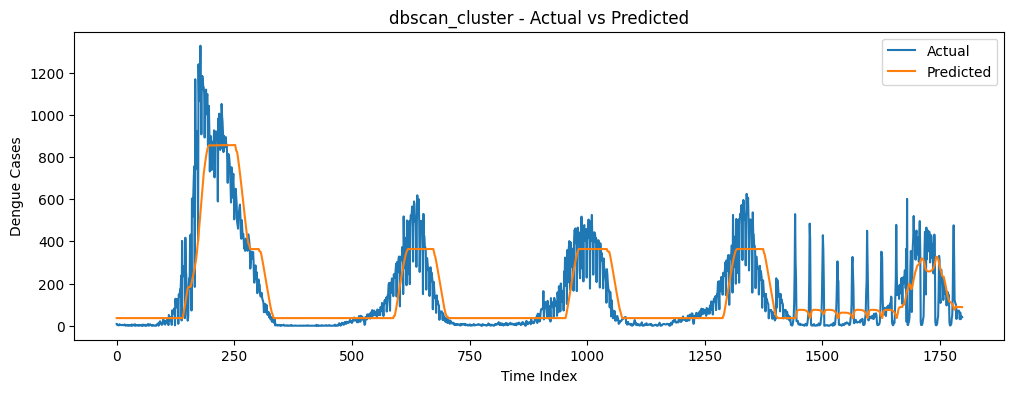


===== Evaluation for agglo_cluster =====


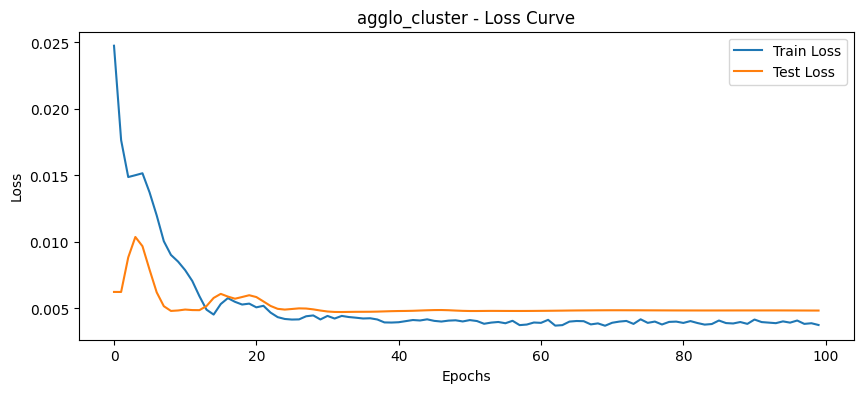

MAE: 79.29, MSE: 14363.62, R²: 0.7227


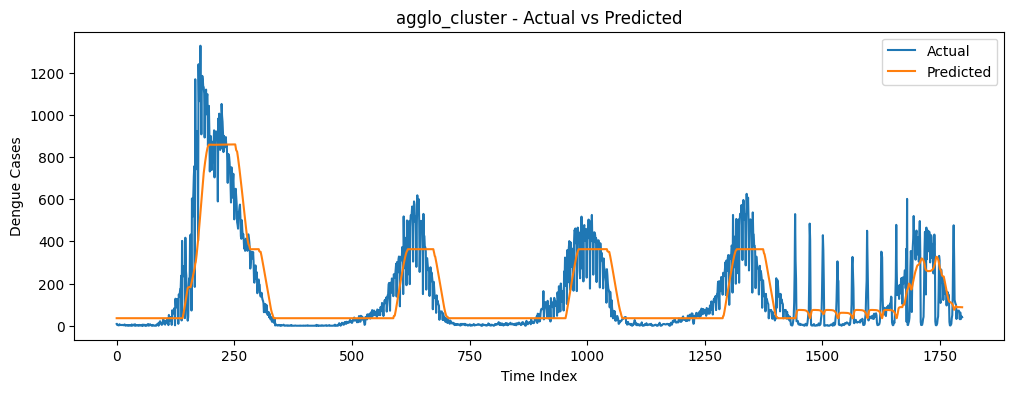


===== Evaluation for spectral_cluster =====


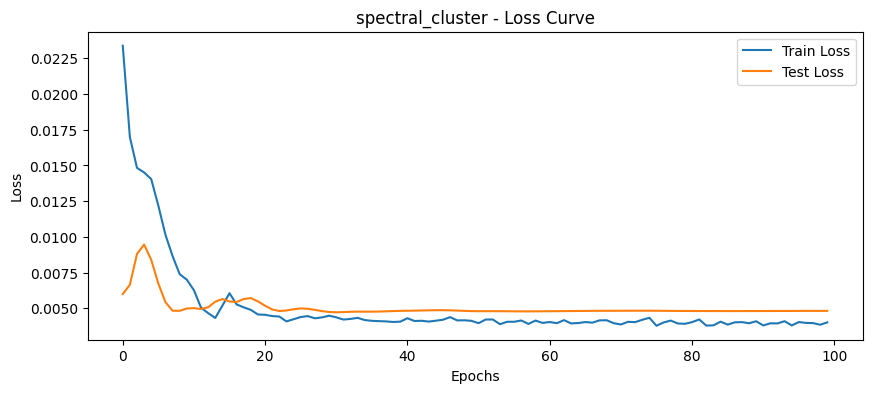

MAE: 79.96, MSE: 14428.62, R²: 0.7215


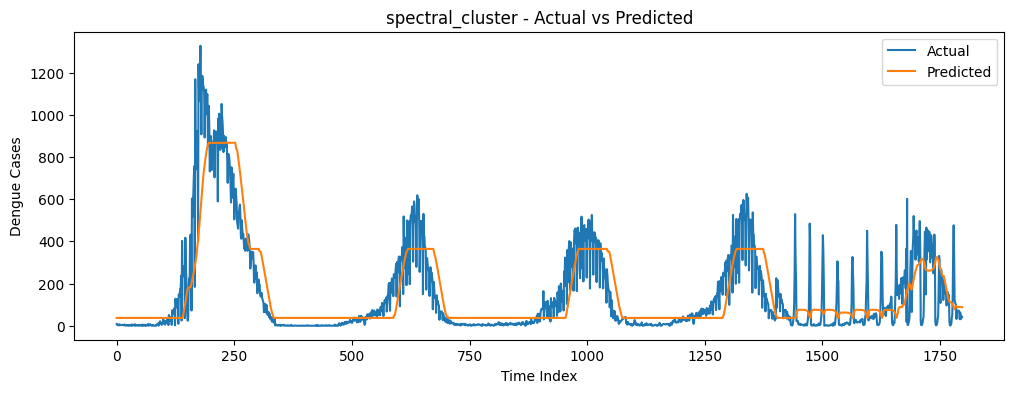


===== Evaluation for louvain_cluster =====


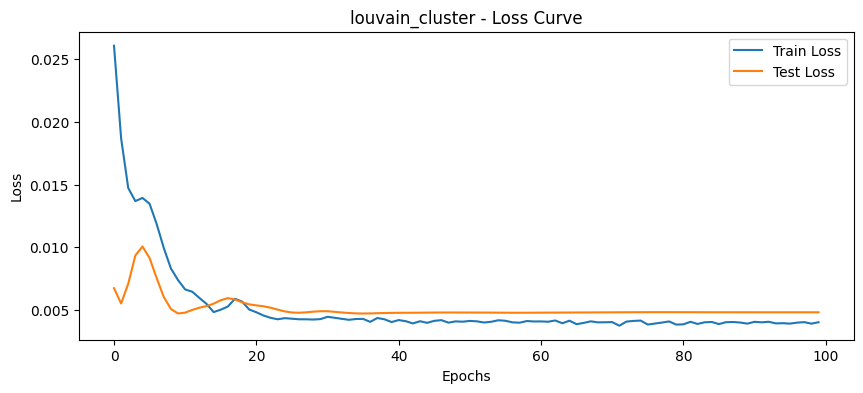

MAE: 79.83, MSE: 14489.67, R²: 0.7203


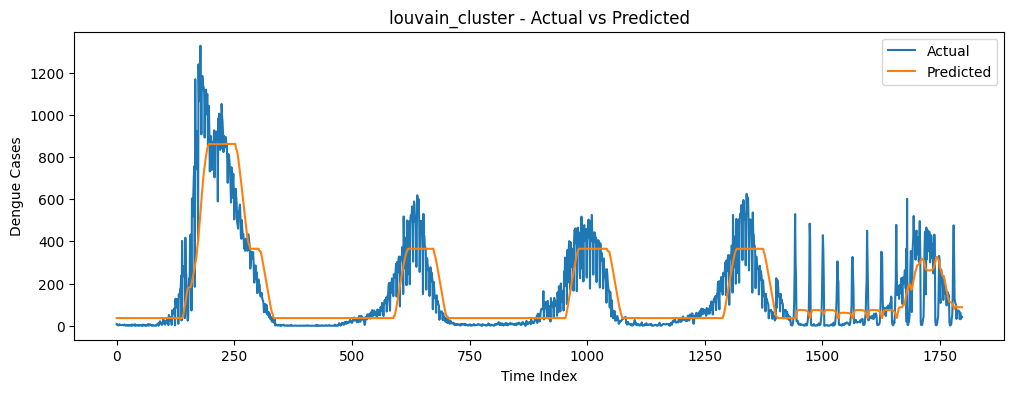

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

for cluster_col in cluster_methods:
    print(f"\n===== Evaluation for {cluster_col} =====")
    res = results[cluster_col]

    train_losses = res['train_losses']
    test_losses = res['test_losses']
    model = res['model']

    # --- Plot Train vs Test Loss ---
    plt.figure(figsize=(10,4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title(f'{cluster_col} - Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # --- Predictions & Regression Metrics ---
    model.eval()
    with torch.no_grad():
        X_feat, y_feat, scaler_y = prepare_features(cluster_col)
        X_feat, y_feat = X_feat.to(device), y_feat.to(device)
        pred_scaled = model(X_feat,A).cpu().numpy()
        y_true_scaled = y_feat.cpu().numpy()

        # Inverse scaling
        pred = scaler_y.inverse_transform(pred_scaled)
        y_true = scaler_y.inverse_transform(y_true_scaled)

        # Align lengths (sequence effect)
        min_len = min(len(pred), len(y_true))
        pred = pred[-min_len:]
        y_true = y_true[-min_len:]

        # Regression metrics
        mae = mean_absolute_error(y_true, pred)
        mse = mean_squared_error(y_true, pred)
        r2 = r2_score(y_true, pred)
        print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, R²: {r2:.4f}")

        # --- Plot Actual vs Predicted ---
        plt.figure(figsize=(12,4))
        plt.plot(y_true, label='Actual')
        plt.plot(pred, label='Predicted')
        plt.title(f'{cluster_col} - Actual vs Predicted')
        plt.xlabel('Time Index')
        plt.ylabel('Dengue Cases')
        plt.legend()
        plt.show()


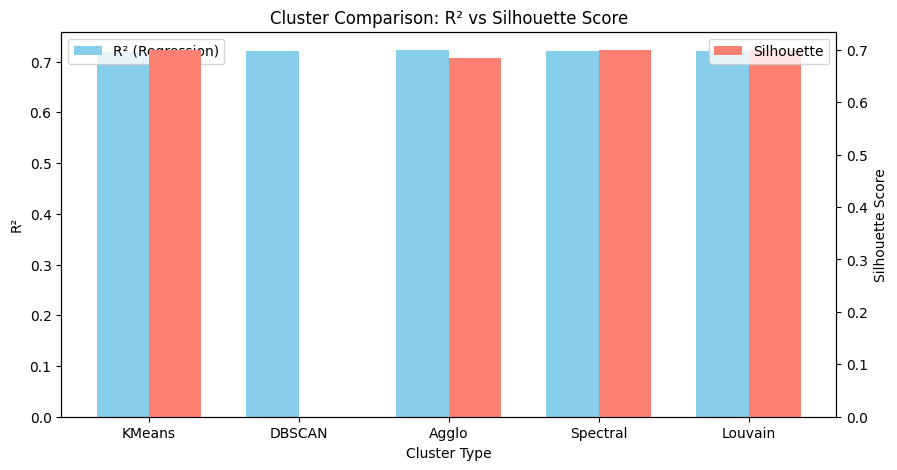

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Cluster names
clusters = ['KMeans', 'DBSCAN', 'Agglo', 'Spectral', 'Louvain']

# Regression metric (R²)
r2_scores = [0.7197, 0.7217, 0.7227, 0.7215, 0.7203]

# Silhouette Scores
sil_scores = [0.6994, np.nan, 0.6838, 0.6994, 0.6994]  # DBSCAN silhouette not available

x = np.arange(len(clusters))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10,5))

# R² bars
rects1 = ax1.bar(x - width/2, r2_scores, width, label='R² (Regression)', color='skyblue')

# Silhouette bars (secondary axis)
ax2 = ax1.twinx()
rects2 = ax2.bar(x + width/2, sil_scores, width, label='Silhouette', color='salmon')

# Labels and ticks
ax1.set_xlabel('Cluster Type')
ax1.set_ylabel('R²')
ax2.set_ylabel('Silhouette Score')
ax1.set_title('Cluster Comparison: R² vs Silhouette Score')
ax1.set_xticks(x)
ax1.set_xticklabels(clusters)

# Legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()
